In [52]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

from pandas.io import wb
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os, time
import itertools

from wb_api_wraper import *
from progress_reporter import *
from sorted_nicely import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



###WB data

In [53]:
#population from WB (ot chack popluation from Landscan)
pop      =get_wb_mrv('SP.POP.TOTL'      ,"pop").squeeze()#population

In [54]:
#country dictionaries
iso_country = pd.read_csv("iso3_to_wb_name.csv", index_col = "iso3", squeeze=True)
name_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)

###population from landscan

In [55]:
#total pop from landscan
h=pd.read_csv("pop_landscan_0703.csv")
h.columns = h.columns.str.lower()
h["country"]=h.admin.replace(name_wb_name)
pop_landscan = h.rename(columns=dict(pylssum="pop")).dropna().set_index("country")["pop"] 

country
Aruba                             0.725556
Bahamas, The                      0.742040
Bahrain                           0.749171
Cyprus                            0.590476
Equatorial Guinea                 0.747002
Faeroe Islands                    0.718945
French Polynesia                  0.685429
Greenland                         0.303881
Kiribati                          0.244232
Kuwait                            0.756923
Maldives                          0.368121
Marshall Islands                  0.075798
Norway                            0.788198
Oman                              0.776241
Palau                             0.667109
Papua New Guinea                  0.794891
Samoa                             0.752063
Solomon Islands                   0.604055
Somalia                           0.694482
St. Kitts and Nevis               0.701637
St. Vincent and the Grenadines    0.666722
Tonga                             0.479628
Tuvalu                            0.070447
Uni

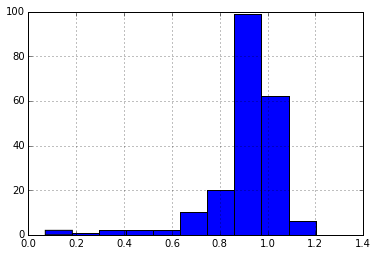

In [56]:
#compares population in landscan with population in WB
test=(pop_landscan/pop)
test.hist()
test[test<.8]

###data on exposure per bassin per country per hydro return period

In [57]:
# adapts chaging raw data to current code
translator ={'iso_a3':"country_iso", "fpu_id":"fpu_id", 'lssum':'fpu_population', 'py5sum':"5", 'py10sum':"10",
        'py25sum':"25",  'py50sum':"50",  'py100sum':"100", 'py250sum':"250",  'py500sum':"500",  'py1000sum':"1000",
        'admin':'name'}
#Reads data 
ebp=pd.read_csv("basins_0702_adrien.csv")
#translates random column names to what i want to use
ebp.columns=ebp.columns.str.lower()
ebp =ebp.rename(columns=translator)[sorted_nicely(list(translator.values()))];

ebp.head()

,5,10,25,50,100,250,500,1000,country_iso,fpu_id,fpu_population,name
0,0,0,0,0,0,0,0,0,AFG,20,472,Afghanistan
1,34094,73400,102266,104100,105534,105828,116724,117383,AFG,172,2791282,Afghanistan
2,322025,461759,539858,565776,599214,635334,651817,680372,AFG,188,7392882,Afghanistan
3,47,74,1243,1364,1364,4447,4854,4854,AFG,205,135807,Afghanistan
4,1659,1798,1907,2256,2275,2499,2754,2905,AFG,206,21637,Afghanistan


In [58]:
ebp["country"] = ebp.name.replace(name_wb_name)
print("Places ignored\n"+", ".join([str(c) for c in ebp.country.unique() if c not in iso_country.unique()]+list(ebp.ix[ebp.country.isnull()].name.unique())))
ebp= ebp.dropna()

Places ignored
Akrotiri Sovereign Base Area, nan, Baykonur Cosmodrome, Cura̤ao, Cyprus No Mans Area, Dhekelia Sovereign Base Area, Kosovo, Northern Cyprus, Palestine, São Tomé and Príncipe, Siachen Glacier, Somaliland, US Naval Base Guantanamo Bay, Aland, Falkland Islands, Gibraltar, Guernsey, Jersey, Montserrat, Saint Pierre and Miquelon, Vatican, Western Sahara


###index by country,bassin

In [59]:
#Reshaping

#return periods
col_names = {'5':5, '10':10, '25':25, '50':50, '100':100, '250':250, '500':500, '1000':1000}
p = sorted(list(col_names.values()))  #" return periods (with 2 added)

#reshaping
expo_bassin = ebp.set_index(["country","fpu_id"]).drop(["country_iso","name"],axis=1).sortlevel().rename(columns=col_names)

#separates exposure and total population
pop_bassin_country = expo_bassin["fpu_population"]
expo_bassin = expo_bassin[p]

#Assumes nobody exposed under 5 years
expo_bassin[0]=expo_bassin[5]

#Assume 2 and 5 yr exposure are equal
#expo_bassin[2]=expo_bassin[5];
#p=sorted(p+[2])

expo_bassin.sort_index(axis=1,inplace=True)

#number of people exposed in each country,bassin
expo_bassin.head()

0       5       10      25      50      100     250   \
country     fpu_id                                                           
Afghanistan 20           0       0       0       0       0       0       0   
            172      34094   34094   73400  102266  104100  105534  105828   
            188     322025  322025  461759  539858  565776  599214  635334   
            205         47      47      74    1243    1364    1364    4447   
            206       1659    1659    1798    1907    2256    2275    2499   

                      500     1000  
country     fpu_id                  
Afghanistan 20           0       0  
            172     116724  117383  
            188     651817  680372  
            205       4854    4854  
            206       2754    2905

Countries with missmatch between tot pop and bassin pop country
Aruba                       0.000021
St. Lucia                   0.525274
Turks and Caicos Islands    0.476926
Vanuatu                     0.892374
Virgin Islands, British     0.828344
dtype: float64

 Countries with missmatch between tot pop and bassin pop Series([], dtype: float64)


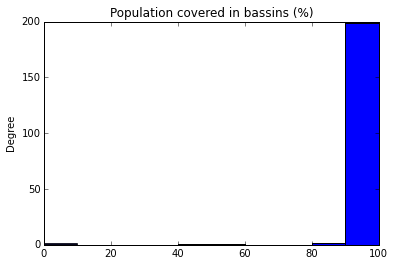

In [60]:
#Country population sanity check
check = (pop_bassin_country.sum(level="country")/pop_landscan)
(100*check).plot(kind="hist",title="Population covered in bassins (%)")
print("Countries with missmatch between tot pop and bassin pop",check[check<.9])
check.to_csv("pop_covered_bassins.csv")
print("\n Countries with missmatch between tot pop and bassin pop",check[check>1])
del check

In [61]:
#Bassin population sanity check (same bassin should be different accross countries)
expo_bassin.reset_index().set_index("fpu_id").sort_index().head()

,country,0,5,10,25,50,100,250,500,1000
fpu_id,,,,,,,,,,
2,Greenland,0,0,0,0,0,0,0,0,0
3,Russian Federation,362,362,442,546,578,612,660,679,689
4,Russian Federation,3318,3318,4469,5036,5462,5705,6047,6217,6458
5,Canada,2520,2520,2556,3522,3862,4193,4193,4194,4856
5,United States,1364,1364,1603,1674,1793,1804,1848,1918,1930


###Simulates events

In [62]:
from scipy.interpolate import interp1d

In [63]:
#theory
q = [0]+[1-1/x for x in p]+[1]
q=pd.Series(np.diff(q),index=[0]+p)
print("probas\n",q)

#using quantiles to compute return periods
quant = [1-1/x for x in p]
#quant[0]=0.805 #works around numerical bug with only one bassin
print("Quantiles:" ,quant)

probas
 0       0.800
5       0.100
10      0.060
25      0.020
50      0.010
100     0.006
250     0.002
500     0.001
1000    0.001
dtype: float64
Quantiles: [0.8, 0.9, 0.96, 0.98, 0.99, 0.996, 0.998, 0.999]


In [64]:
#Number of simulations per (country, bassin) 
n=int(1e5)

#preallocating dataframe of result
result=pd.DataFrame(columns=ebp.country.unique(), index=quant)

for c in result.columns:#loop on countries

    events = pd.DataFrame(index=range(0,n), columns=expo_bassin.ix[c].index).fillna(0)
    events.name="sce"
    for f in events.columns:#loop on bassins in the country
        
        progress_reporter((c,f))
        
        x=expo_bassin.ix[c,f]
        rand=np.power(np.random.random(n),-1)
        
        events[f]=interp1d(x.index,x, fill_value=x[1000], bounds_error=False)( rand)

    result[c] =(events.sum(axis=1)/pop_landscan.ix[c]).quantile(quant)

result = result.transpose()
result.index.name="country"
result.columns=p


('Zimbabwe', 399)


In [65]:
result.head()

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Afghanistan,0.071883,0.075220,0.080792,0.083031,0.085474,0.088782,0.090466,0.091854
Akrotiri Sovereign Base Area,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Albania,0.044306,0.061365,0.071577,0.072555,0.073566,0.074547,0.075178,0.076891
Algeria,0.028817,0.030046,0.032331,0.033595,0.034603,0.035962,0.036480,0.037174
Andorra,0.142728,0.146793,0.280933,0.280933,0.280933,0.293359,0.293741,0.293741


In [67]:
result.to_csv("exposure_econ_return_period.csv",encoding="utf-8")

###Comparing with previous, erroneous, method

In [68]:
result[result==0].dropna(how="all")  #make sure there is no line with 0 in the first column but no other column

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Akrotiri Sovereign Base Area,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0
Aruba,0,0,0,0,0,0,0,0
Bahrain,0,0,0,0,0,0,0,0
Barbados,0,0,0,0,0,0,0,0
"Virgin Islands, British",0,0,0,0,0,0,0,0
Comoros,0,0,0,0,0,0,0,0
Cura̤ao,0,0,0,0,0,0,0,0
Cyprus,0,0,0,0,0,0,0,0


,0,5,10,25,50,100,250,500,1000
country,,,,,,,,,
Afghanistan,,1.114156,,,,,,,
Albania,,1.003217,1.000969,1.000159,1.000291,,,,
Algeria,,1.077659,,,,,,,
Andorra,,1.065246,,,,,,,
Angola,,1.027603,,,,,,,
Argentina,,1.09324,,,,,,,
Armenia,,1.003579,,1,1.000546,1.002057,1.003354,1.000061,
Australia,,1.083732,,,,,,,
Austria,,1.139594,,,,,,,


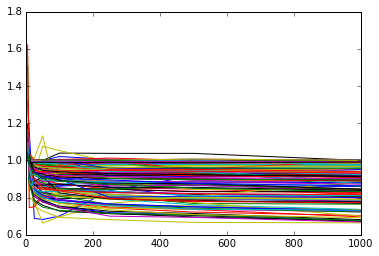

In [69]:
compare = result/(expo_bassin.sum(level="country").div(pop_landscan,axis=0))
compare.transpose().plot(legend=None)
compare[compare>1].dropna(how="all").fillna(" ")